This notebook studies the applicability of b/c-tagging event vetoes on signal samples of representative parameter points. **Triggered only**.

For 102x, [central Btag recommendations](https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X) provide working points for DeepCSV and DeepFlavour.

In [13]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot
import awkward

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.metfilter import MetFilters

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import json

dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

**b tagger**

|       | loose | medium | tight |
|-------|-------|--------|-------|
|DeepCSV|0.1241 | 0.4184 | 0.7527|
|DeepJet|0.0494 | 0.2770 | 0.7264|

In [6]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal datasets')
        quality_axis = hist.Cat('wp', 'working points')
        tagger_axis = hist.Cat('tagger', 'tagger name')
        multiplicity_axis = hist.Bin('multi', '#b-tagged/event', 6, 0, 6)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist('A.U.', dataset_axis, quality_axis, tagger_axis, multiplicity_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        deepcsv_b = df['hftagscore_DeepCSV_b']
        deepjet_b = df['hftagscore_DeepFlavour_b']
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
#         triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        
        deepcsv_b = deepcsv_b[metfiltermask]
        deepjet_b = deepjet_b[metfiltermask]
        
        output['multi'].fill(dataset=dataset, tagger='DeepCSV', wp='loose', multi=deepcsv_b[deepcsv_b>0.1241].counts)
        output['multi'].fill(dataset=dataset, tagger='DeepCSV', wp='medium', multi=deepcsv_b[deepcsv_b>0.4184].counts)
        output['multi'].fill(dataset=dataset, tagger='DeepCSV', wp='tight', multi=deepcsv_b[deepcsv_b>0.7527].counts)
        
        output['multi'].fill(dataset=dataset, tagger='DeepJet', wp='loose', multi=deepjet_b[deepjet_b>0.0494].counts)
        output['multi'].fill(dataset=dataset, tagger='DeepJet', wp='medium', multi=deepjet_b[deepjet_b>0.2770].counts)
        output['multi'].fill(dataset=dataset, tagger='DeepJet', wp='tight', multi=deepjet_b[deepjet_b>0.7264].counts)
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- lxy: 0.3cm

In [7]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:03<00:00,  6.64items/s]


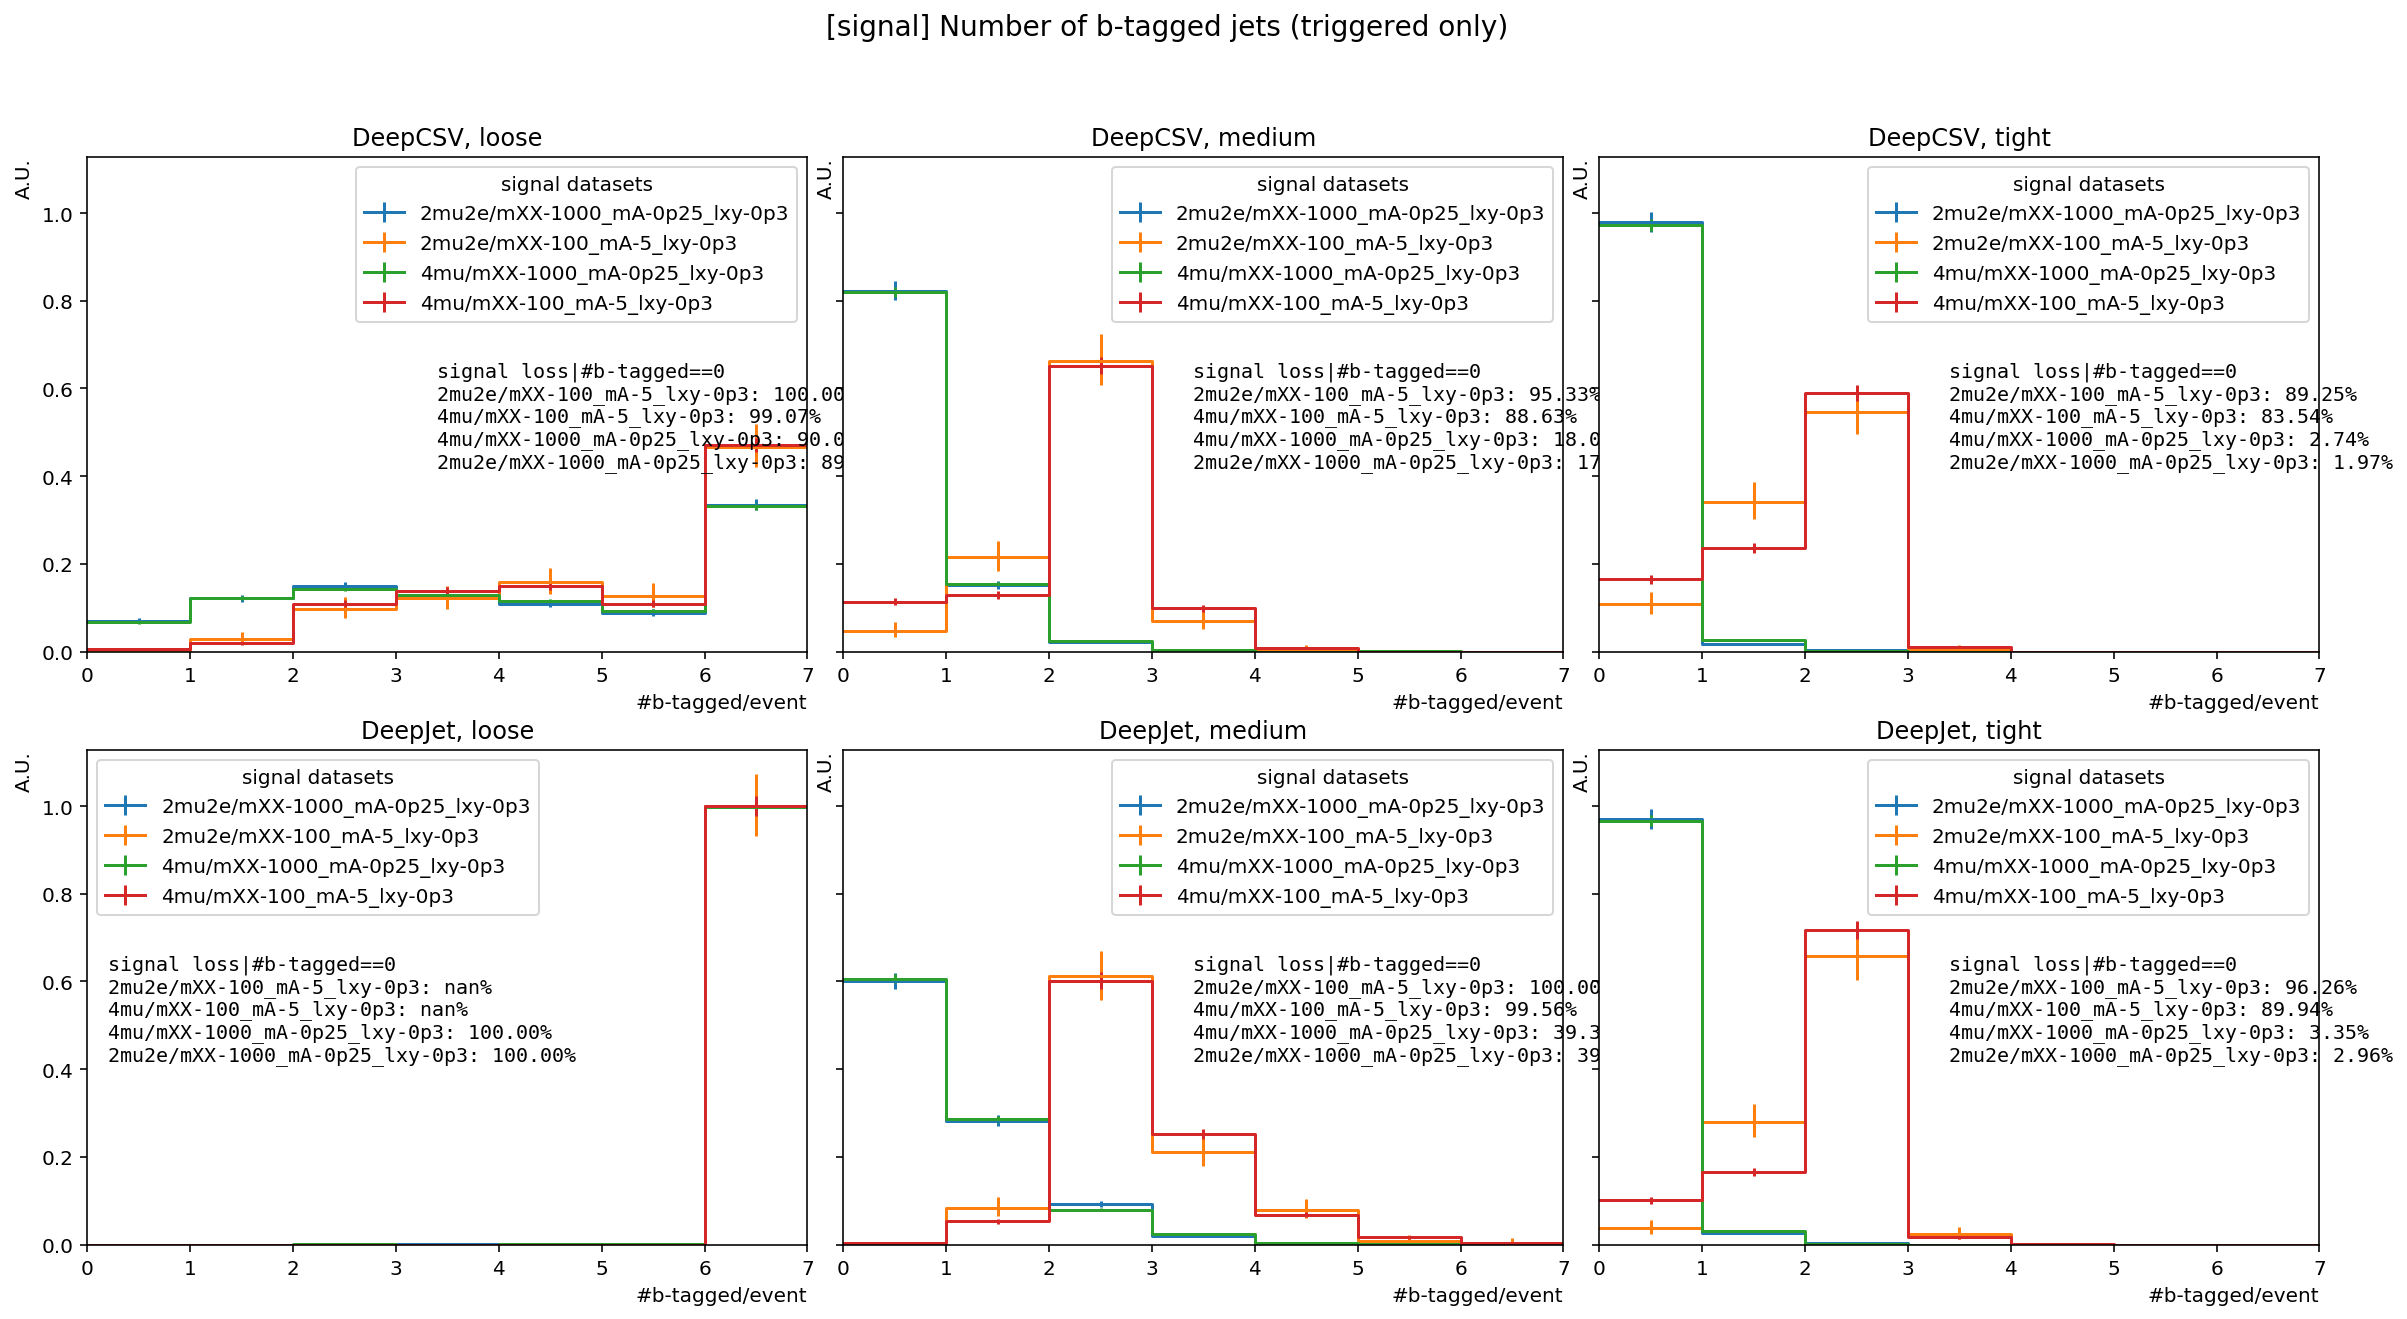

In [8]:
fig, _ = plt.subplots(2,3,figsize=(20,10), gridspec_kw={'wspace': 0.05}, sharey=True)
fig, axes = hist.plotgrid(output['multi'], figure=fig, col='wp', row='tagger', overlay='dataset', overflow='over', density=True)
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
plt.suptitle('[signal] Number of b-tagged jets (triggered only)', fontsize=14)

# print signal loss when require #btag==0
from collections import defaultdict
res = defaultdict(lambda: defaultdict(dict))
for c, vals in output['multi'].values().items():
    loss = 1-vals[0]/np.sum(vals)
    res[c[2]][c[1]][c[0]] = loss
restext = defaultdict(dict)
for tagger in res:
    for wp in res[tagger]:
        text_ = ['signal loss|#b-tagged==0',]
        for x, v in res[tagger][wp].items():
            text_.append("{:22}: {:.2%}".format(x, v))
        restext[tagger][wp] = '\n'.join(text_)
axes[0][0].text(3.4, 0.42, restext['DeepCSV']['loose'], family='monospace')
axes[0][1].text(3.4, 0.42, restext['DeepCSV']['medium'], family='monospace')
axes[0][2].text(3.4, 0.42, restext['DeepCSV']['tight'], family='monospace')
axes[1][0].text(0.2, 0.42, restext['DeepJet']['loose'], family='monospace')
axes[1][1].text(3.4, 0.42, restext['DeepJet']['medium'], family='monospace')
axes[1][2].text(3.4, 0.42, restext['DeepJet']['tight'], family='monospace');

- lxy: 300cm

In [9]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  4.98items/s]


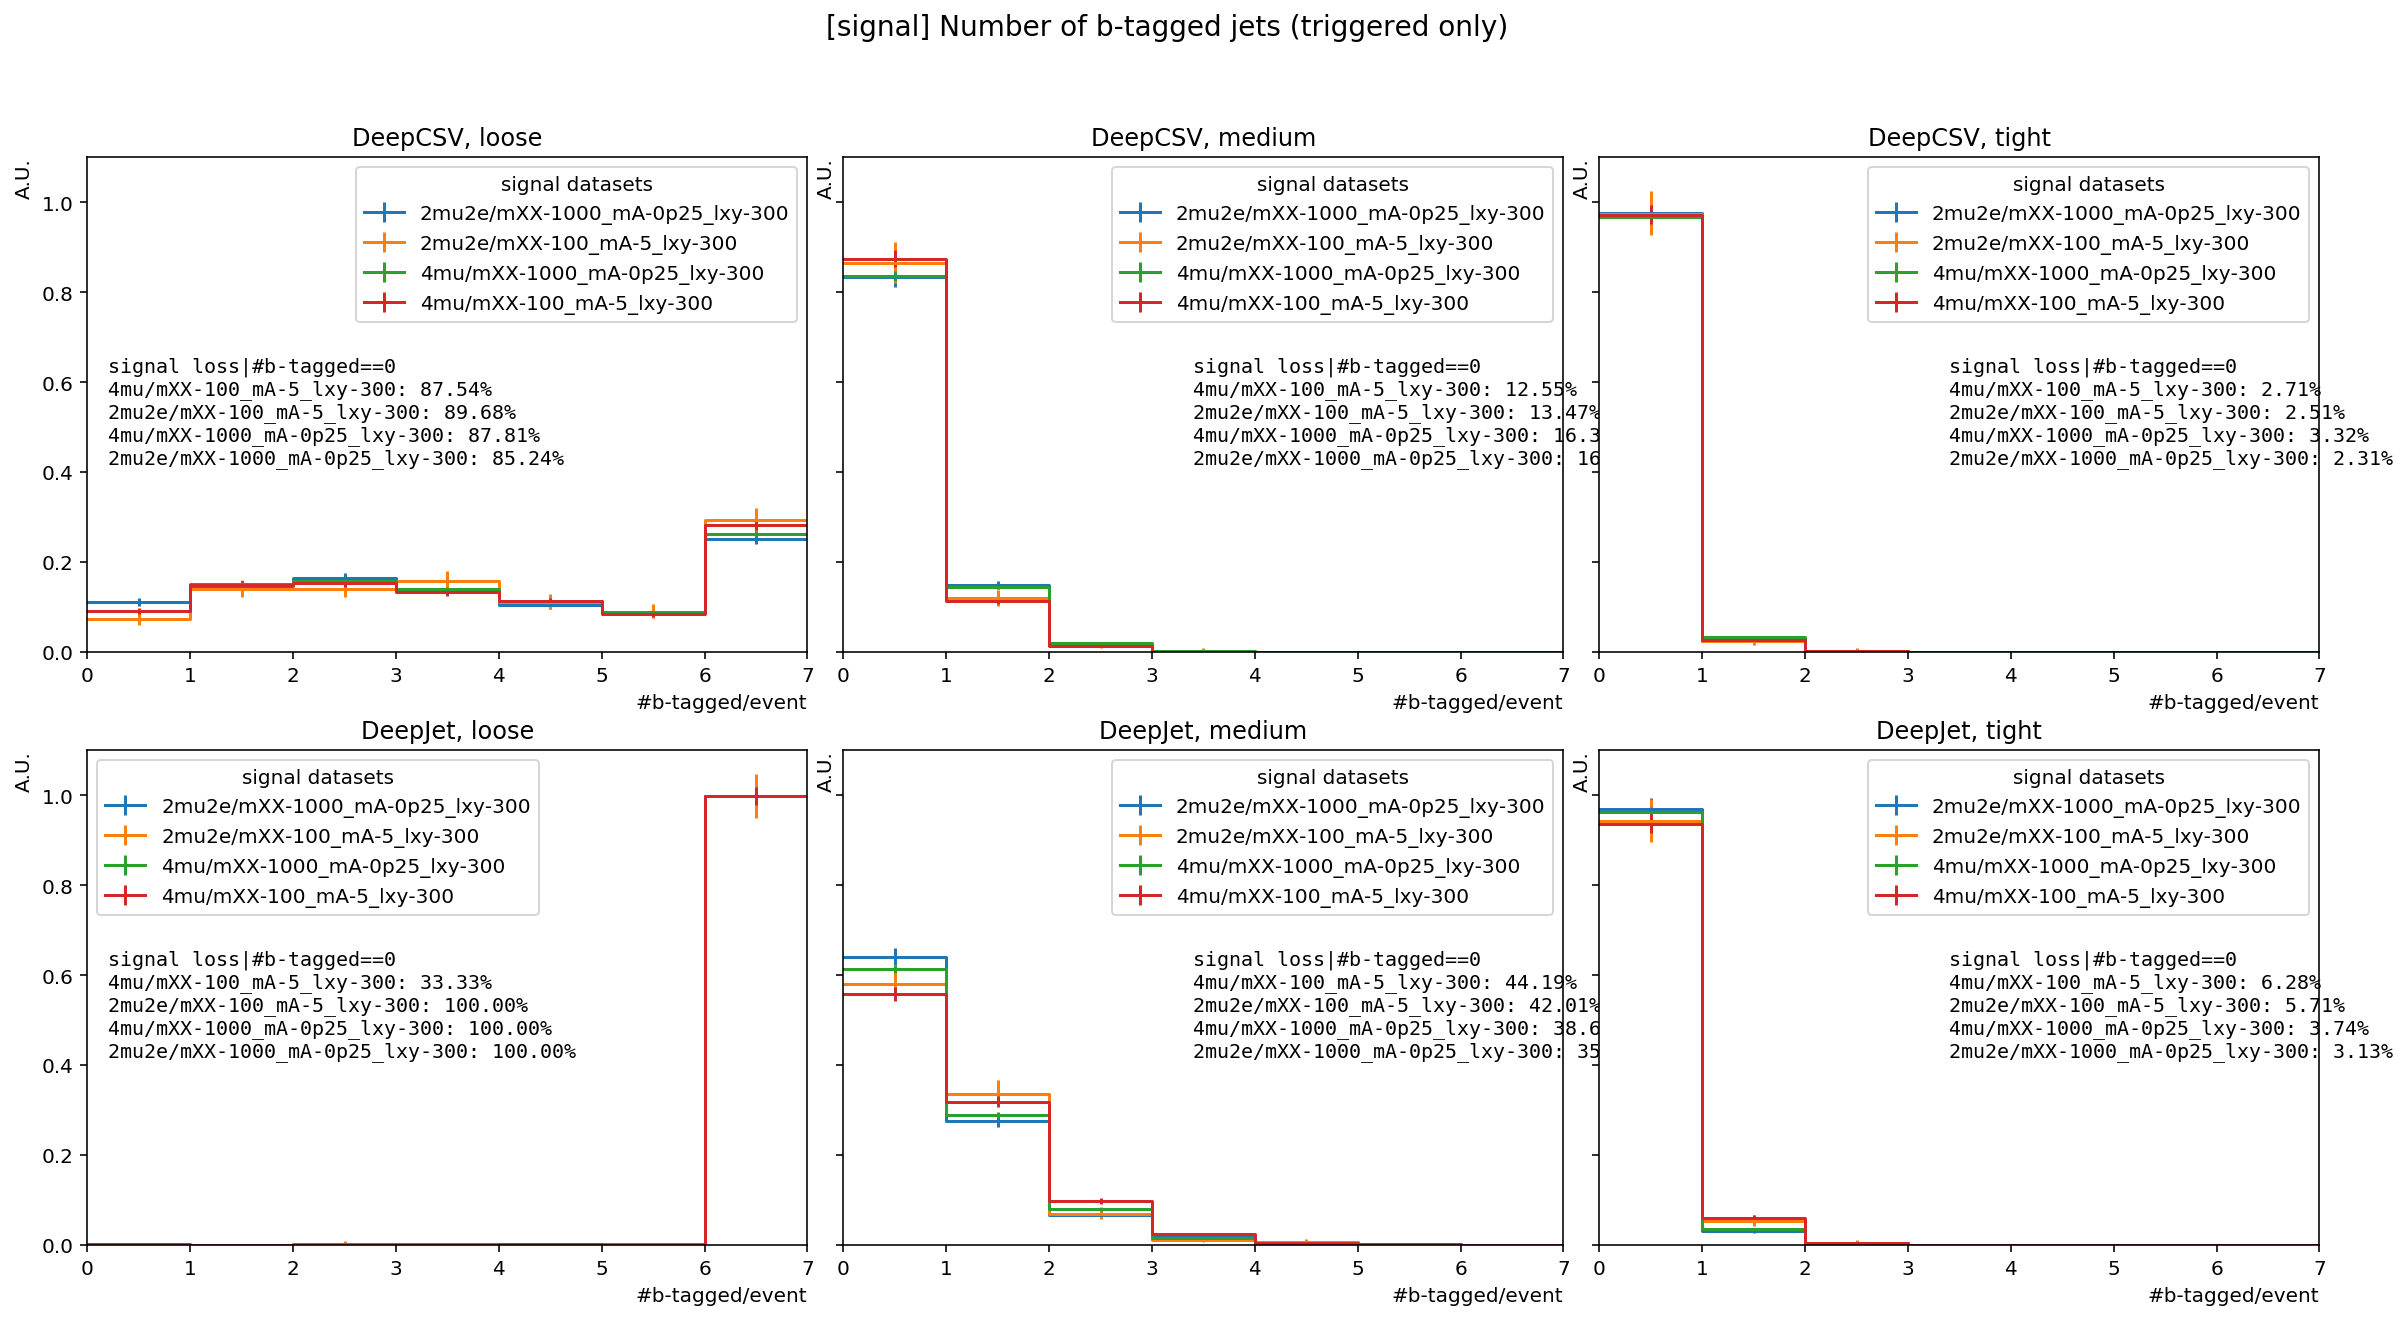

In [10]:
fig, _ = plt.subplots(2,3,figsize=(20,10), gridspec_kw={'wspace': 0.05}, sharey=True)
fig, axes = hist.plotgrid(output['multi'], figure=fig, col='wp', row='tagger', overlay='dataset', overflow='over', density=True)
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
plt.suptitle('[signal] Number of b-tagged jets (triggered only)', fontsize=14)

# print signal loss when require #btag==0
from collections import defaultdict
res = defaultdict(lambda: defaultdict(dict))
for c, vals in output['multi'].values().items():
    loss = 1-vals[0]/np.sum(vals)
    res[c[2]][c[1]][c[0]] = loss
restext = defaultdict(dict)
for tagger in res:
    for wp in res[tagger]:
        text_ = ['signal loss|#b-tagged==0',]
        for x, v in res[tagger][wp].items():
            text_.append("{:22}: {:.2%}".format(x, v))
        restext[tagger][wp] = '\n'.join(text_)
axes[0][0].text(0.2, 0.42, restext['DeepCSV']['loose'], family='monospace')
axes[0][1].text(3.4, 0.42, restext['DeepCSV']['medium'], family='monospace')
axes[0][2].text(3.4, 0.42, restext['DeepCSV']['tight'], family='monospace')
axes[1][0].text(0.2, 0.42, restext['DeepJet']['loose'], family='monospace')
axes[1][1].text(3.4, 0.42, restext['DeepJet']['medium'], family='monospace')
axes[1][2].text(3.4, 0.42, restext['DeepJet']['tight'], family='monospace');

**leptonejet neutralness**

In [11]:
class LeptonjetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        charge_axis = hist.Bin('charge', 'leptonjet charge sum', 7, -3, 4)
        self._accumulator = processor.dict_accumulator({
            'charge': hist.Hist('counts', dataset_axis, charge_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset = df['dataset']
        
        ljcharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        output['charge'].fill(dataset=dataset, charge=ljcharge.flatten())
        return output
    
    def postprocess(self, accu):
        return accu

In [23]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonjetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:03<00:00,  6.65items/s]


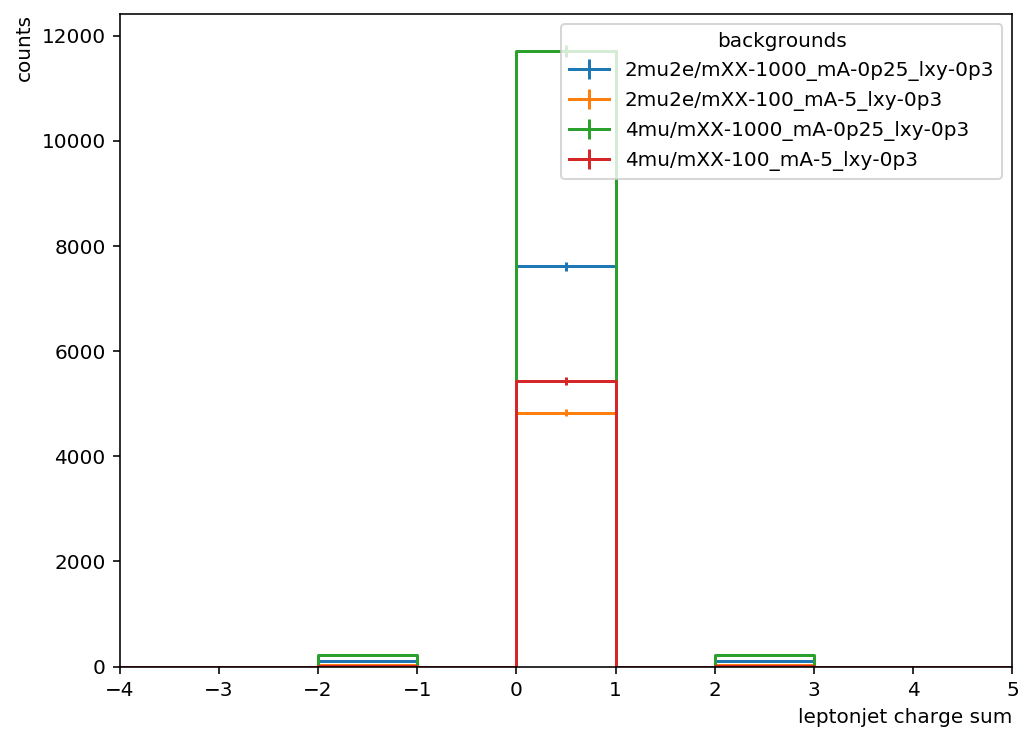

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['charge'], overlay='dataset', ax=ax, overflow='all')

ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [24]:
import pandas as pd
hdf = pd.DataFrame(output['charge'].values(overflow='all')).transpose()
hdf.columns = np.arange(-4,5)
hdf

,-4,-3,-2,-1,0,1,2,3,4
2mu2e/mXX-100_mA-5_lxy-0p3,0.0,0.0,27.0,0.0,4830.0,0.0,23.0,0.0,0.0
4mu/mXX-1000_mA-0p25_lxy-0p3,0.0,0.0,215.0,0.0,11708.0,0.0,220.0,0.0,1.0
4mu/mXX-100_mA-5_lxy-0p3,0.0,0.0,11.0,0.0,5426.0,0.0,14.0,0.0,0.0
2mu2e/mXX-1000_mA-0p25_lxy-0p3,0.0,0.0,109.0,0.0,7613.0,0.0,111.0,0.0,0.0


In [25]:
hdf['neutral%'] = hdf[0]/hdf.sum(axis=1)*100
hdf['charged%'] = 100-hdf['neutral%']
hdf[['neutral%', 'charged%']]

,neutral%,charged%
2mu2e/mXX-100_mA-5_lxy-0p3,98.975410,1.024590
4mu/mXX-1000_mA-0p25_lxy-0p3,96.409750,3.590250
4mu/mXX-100_mA-5_lxy-0p3,99.541369,0.458631
2mu2e/mXX-1000_mA-0p25_lxy-0p3,97.191370,2.808630


- lxy: 300cm

In [17]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonjetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:03<00:00,  6.65items/s]


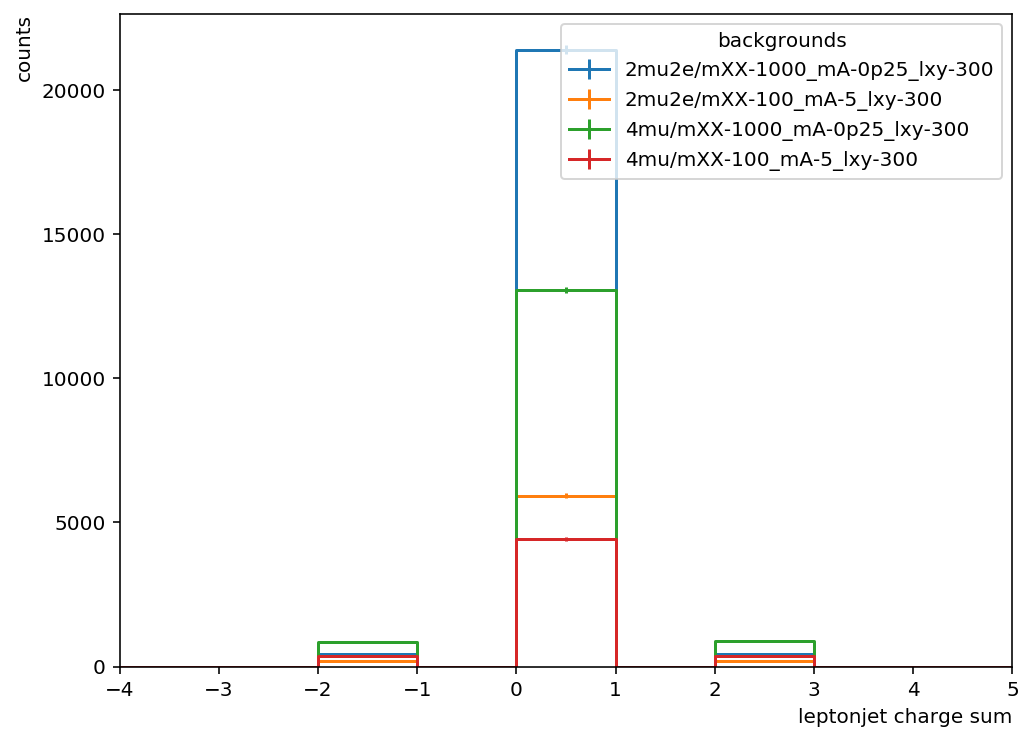

In [18]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
hist.plot1d(output['charge'], overlay='dataset', ax=ax, overflow='all')

ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [21]:
import pandas as pd
hdf = pd.DataFrame(output['charge'].values(overflow='all')).transpose()
hdf.columns = np.arange(-4,5)
hdf

,-4,-3,-2,-1,0,1,2,3,4
4mu/mXX-100_mA-5_lxy-300,1.0,0.0,364.0,0.0,4418.0,0.0,367.0,0.0,1.0
4mu/mXX-1000_mA-0p25_lxy-300,0.0,0.0,836.0,0.0,13057.0,0.0,882.0,0.0,0.0
2mu2e/mXX-100_mA-5_lxy-300,1.0,0.0,202.0,0.0,5926.0,0.0,188.0,0.0,2.0
2mu2e/mXX-1000_mA-0p25_lxy-300,0.0,0.0,452.0,0.0,21398.0,0.0,425.0,0.0,0.0


In [22]:
hdf['neutral%'] = hdf[0]/hdf.sum(axis=1)*100
hdf['charged%'] = 100-hdf['neutral%']
hdf[['neutral%', 'charged%']]

,neutral%,charged%
4mu/mXX-100_mA-5_lxy-300,85.769753,14.230247
4mu/mXX-1000_mA-0p25_lxy-300,88.372250,11.627750
2mu2e/mXX-100_mA-5_lxy-300,93.780661,6.219339
2mu2e/mXX-1000_mA-0p25_lxy-300,96.062851,3.937149
